## 1. Load Required Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from collections import defaultdict


## 2. Define Distance Calculation Function
This function computes the distance matrix between train and test sets using either cosine similarity or Euclidean distance.

In [2]:

def calculate_distance_matrix(X_train, X_test, metric="cosine"):
    """
    Calculate distance matrix between training and testing sets using the specified metric.

    Args:
        X_train (np.array): Training data (TF-IDF features).
        X_test (np.array): Test data (TF-IDF features).
        metric (str): Distance metric ("cosine" or "euclidean").

    Returns:
        np.array: Distance matrix of shape (len(X_test), len(X_train)).
    """
    if metric == "cosine":
        return cosine_distances(X_test, X_train)
    elif metric == "euclidean":
        return euclidean_distances(X_test, X_train)
    else:
        raise ValueError("Unsupported metric. Use 'cosine' or 'euclidean'.")


## 3. k-NN Prediction
This function predicts labels for the test set by finding the k-nearest neighbors and performing majority voting.

In [3]:
def knn_predict(X_train, y_train, X_test, k, distance_matrix):
    """
    Predict labels for test data using k-NN.

    Args:
        X_train (np.array): Training data (TF-IDF features).
        y_train (np.array): Training labels.
        X_test (np.array): Test data (TF-IDF features).
        k (int): Number of neighbors.
        distance_matrix (np.array): Precomputed distance matrix.

    Returns:
        np.array: Predicted labels for X_test.
    """
    predictions = []
    for i in range(distance_matrix.shape[0]):
        # Get the k nearest neighbors
        neighbors_idx = np.argsort(distance_matrix[i])[:k]
        neighbors_labels = y_train[neighbors_idx]
        # Majority voting
        predicted_label = np.bincount(neighbors_labels).argmax()
        predictions.append(predicted_label)
    return np.array(predictions)


## 4. Performance Metrics
This function manually calculates precision, recall, F1-Score, and true/false positives/negatives for each class.


In [4]:
def manual_metrics(y_true, y_pred, classes):
    """
    Manually calculate Precision, Recall, F1-Score, TP, FP, FN for each class.

    Args:
        y_true (np.array): True labels.
        y_pred (np.array): Predicted labels.
        classes (list): List of unique class labels.

    Returns:
        dict: Dictionary with metrics for each class and macro/micro averages.
    """
    metrics = defaultdict(dict)
    total_tp, total_fp, total_fn = 0, 0, 0

    for cls in classes:
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = (
            2 * precision * recall / (precision + recall)
            if (precision + recall) > 0
            else 0.0
        )

        metrics[cls]["TP"] = tp
        metrics[cls]["FP"] = fp
        metrics[cls]["FN"] = fn
        metrics[cls]["Precision"] = precision
        metrics[cls]["Recall"] = recall
        metrics[cls]["F1"] = f1

        total_tp += tp
        total_fp += fp
        total_fn += fn

    # Macro averages
    macro_precision = np.mean([metrics[cls]["Precision"] for cls in classes])
    macro_recall = np.mean([metrics[cls]["Recall"] for cls in classes])
    macro_f1 = np.mean([metrics[cls]["F1"] for cls in classes])

    # Micro averages
    micro_precision = total_tp / (total_tp + total_fp)
    micro_recall = total_tp / (total_tp + total_fn)
    micro_f1 = (
        2 * micro_precision * micro_recall / (micro_precision + micro_recall)
        if (micro_precision + micro_recall) > 0
        else 0.0
    )

    metrics["Macro Average"] = {
        "Precision": macro_precision,
        "Recall": macro_recall,
        "F1": macro_f1,
    }
    metrics["Micro Average"] = {
        "Precision": micro_precision,
        "Recall": micro_recall,
        "F1": micro_f1,
    }

    return metrics


## 5. k-NN with Cross-Validation
Perform stratified 10-fold cross-validation and evaluate k-NN.

In [5]:
def knn_with_cross_validation(X, y, k_values, metric="cosine"):
    """
    Perform stratified 10-fold cross-validation with k-NN.

    Args:
        X (np.array): TF-IDF feature matrix.
        y (np.array): Class labels.
        k_values (list): List of k values to evaluate.
        metric (str): Distance metric ("cosine" or "euclidean").

    Returns:
        dict: Dictionary containing metrics for each k value.
    """
    results = {}
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    classes = np.unique(y)

    for k in k_values:
        fold_metrics = []
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Compute distance matrix
            distance_matrix = calculate_distance_matrix(X_train, X_test, metric)

            # Predict labels
            y_pred = knn_predict(X_train, y_train, X_test, k, distance_matrix)

            # Compute metrics
            metrics = manual_metrics(y_test, y_pred, classes)
            fold_metrics.append(metrics)

        # Average metrics across folds
        avg_metrics = {
            cls: {key: np.mean([fold[cls][key] for fold in fold_metrics]) for key in fold_metrics[0][cls]}
            for cls in classes
        }
        avg_metrics["Macro Average"] = fold_metrics[0]["Macro Average"]
        avg_metrics["Micro Average"] = fold_metrics[0]["Micro Average"]

        results[k] = avg_metrics

    return results


## 6. Run k-NN Classification
Set up data paths, load the dataset, and evaluate performance.

In [6]:
# Load the TF-IDF matrix with labels in the last column
tfidf_path = "reports/tfidf_values.csv"  # Update to the actual path
tfidf_data = pd.read_csv(tfidf_path, index_col=0)

# Separate features (TF-IDF matrix) and labels
X = tfidf_data.iloc[:, :-1].to_numpy()  # All columns except the last are TF-IDF features
y = tfidf_data.iloc[:, -1].to_numpy()   # The last column contains the labels

# Validate dimensions
assert X.shape[0] == len(y), "The number of samples in TF-IDF and labels must match!"

# Define k values and metric
k_values = [1, 3, 5, 7, 9]
metric = "cosine"

# Run k-NN cross-validation
results = knn_with_cross_validation(X, y, k_values, metric)

# Save results to CSV
results_df = pd.DataFrame(results).T
results_df.to_csv("reports/performance_metrics.csv", index=True)

## 7. View Results

Evaluating for metric: cosine
Evaluating for metric: euclidean
Best results of k-NN obtained by: k = 3, similarity metric = cosine


,Metric,Precision,Recall,F-Score,True Positives,False Positives,False Negatives
0,Class 1,0.391871,0.600649,0.473914,45.4,70.6,30.2
1,Class 2,0.605266,0.515940,0.556036,66.4,43.6,62.3
2,Class 3,0.448392,0.346151,0.389716,33.1,40.8,62.5
3,Macro Average,0.528057,0.530016,0.516613,-,-,-
4,Micro Average,0.523333,0.523333,0.523333,-,-,-


The detailed k-NN report has been saved to: reports/detailed_knn_report.csv
Plot saved to reports/knn_performance.png


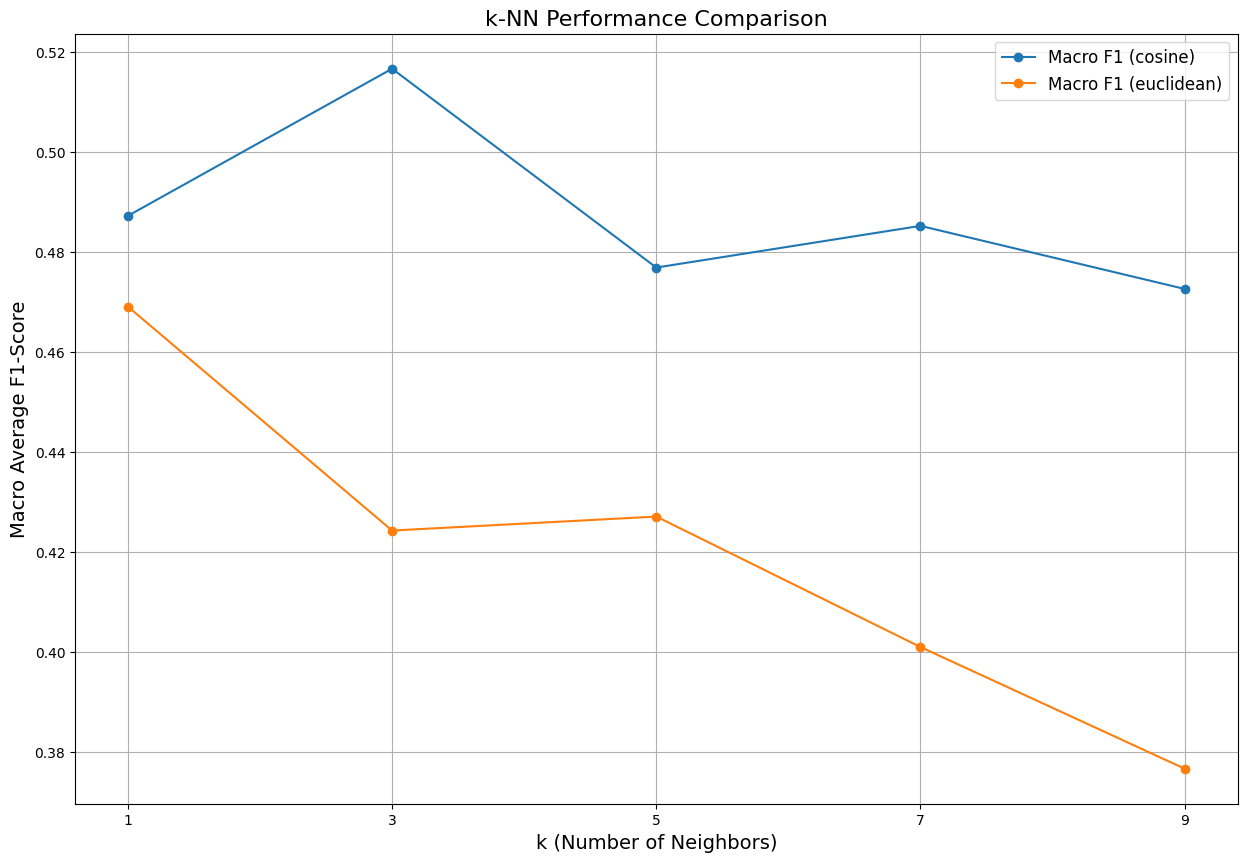

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_knn_metrics(X, y, k_values, metrics):
    """
    Evaluate k-NN performance for multiple similarity metrics and k values.

    Args:
        X (array): Feature matrix (TF-IDF vectors).
        y (array): Labels.
        k_values (list): List of k values to evaluate.
        metrics (list): List of distance metrics (e.g., ['cosine', 'euclidean']).

    Returns:
        dict: Nested dictionary with performance results for each metric and k.
    """
    results = {metric: {} for metric in metrics}
    for metric in metrics:
        print(f"Evaluating for metric: {metric}")
        results[metric] = knn_with_cross_validation(X, y, k_values, metric)
    return results

def generate_detailed_table(results, best_k, similarity_metric):
    """
    Generate and display a detailed performance table for the best k value.

    Args:
        results (dict): Performance metrics for each k and similarity metric.
        best_k (int): The best k value.
        similarity_metric (str): The similarity metric used.

    Returns:
        pd.DataFrame: Detailed performance report.
    """
    best_metrics = results[similarity_metric][best_k]

    # Create rows for the table
    rows = []
    for cls in range(1, 4):  # Classes 1, 2, 3
        cls_metrics = best_metrics[cls]
        rows.append([
            f"Class {cls}",
            cls_metrics["Precision"],
            cls_metrics["Recall"],
            cls_metrics["F1"],
            cls_metrics["TP"],
            cls_metrics["FP"],
            cls_metrics["FN"]
        ])
    
    # Add Macro and Micro averages
    for avg_type in ["Macro Average", "Micro Average"]:
        avg_metrics = best_metrics[avg_type]
        rows.append([
            avg_type,
            avg_metrics["Precision"],
            avg_metrics["Recall"],
            avg_metrics["F1"],
            "-", "-", "-"
        ])

    # Convert to DataFrame
    report_df = pd.DataFrame(rows, columns=[
        "Metric", "Precision", "Recall", "F-Score",
        "True Positives", "False Positives", "False Negatives"
    ])
    return report_df

def plot_knn_performance(results, k_values, metrics, save_path=None):
    """
    Plot and optionally save performance metrics (F1-Score) for different k values and metrics.

    Args:
        results (dict): Results dictionary from evaluate_knn_metrics().
        k_values (list): List of k values.
        metrics (list): List of similarity metrics.
        save_path (str, optional): Path to save the plot image. Default is None.
    """
    plt.figure(figsize=(15, 10))
    
    for metric in metrics:
        macro_f1_scores = [results[metric][k]["Macro Average"]["F1"] for k in k_values]
        plt.plot(k_values, macro_f1_scores, marker='o', label=f'Macro F1 ({metric})')

    plt.title("k-NN Performance Comparison", fontsize=16)
    plt.xlabel("k (Number of Neighbors)", fontsize=14)
    plt.ylabel("Macro Average F1-Score", fontsize=14)
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend(fontsize=12)
    
    # Save the plot if save_path is specified
    if save_path:
        plt.savefig(save_path, format="png", dpi=300, bbox_inches="tight")
        print(f"Plot saved to {save_path}")
    
    plt.show()


# Define k values and similarity metrics
k_values = [1, 3, 5, 7, 9]
metrics = ["cosine", "euclidean"]

# Evaluate performance
results = evaluate_knn_metrics(X, y, k_values, metrics)

# Find best k for cosine metric
best_k_cosine = max(k_values, key=lambda k: results["cosine"][k]["Macro Average"]["F1"])

# Generate and display the detailed table
detailed_table = generate_detailed_table(results, best_k_cosine, similarity_metric="cosine")
print(f"Best results of k-NN obtained by: k = {best_k_cosine}, similarity metric = cosine")
display(detailed_table)

# Save the table to a CSV file
report_path = "reports/detailed_knn_report.csv"
detailed_table.to_csv(report_path, index=False)
print(f"The detailed k-NN report has been saved to: {report_path}")

# Plot results for all metrics
plot_knn_performance(results, k_values, metrics,"reports/knn_performance.png")
